In [1]:
import os
import tarfile
import urllib
import numpy as np
import pickle
import pandas as pd
import datetime
import numpy as np

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
X_PATH = '../datasets/project3trainset.pkl';
Y_PATH = '../datasets/project3trainlabel.pkl';

In [3]:
def load_data(path):
    return pd.read_pickle(path)

In [4]:
#Load Initial Data
x_training = load_data(X_PATH)
y_labels = load_data(Y_PATH)

In [5]:
## View how Data is arranged
from matplotlib import pyplot as plt

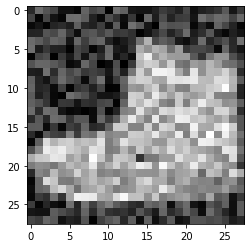

In [6]:
plt.imshow(x_training[0], cmap = 'gray');
#We can see from the values here that they go above 255 values. We want to convert this to 255 values. 

In [7]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
## This is from chapter 10

In [8]:
# Create 2 filters
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

filters = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
from sklearn.model_selection import train_test_split
X_train_full, X_test, y_train_full, y_test=train_test_split(x_training, y_labels, test_size=.3, stratify = y_labels,random_state = 0)

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

#X_train = X_train[..., np.newaxis]
#X_valid = X_valid[..., np.newaxis]
#X_test = X_test[..., np.newaxis]

print(np.shape(X_train_full))
print(np.shape(X_train))
print(np.shape(X_valid))
print(np.shape(X_test))

(38500, 28, 28)
(33500, 28, 28)
(5000, 28, 28)
(16500, 28, 28)


In [10]:
from functools import partial
keras.backend.clear_session()

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=4, activation='relu', padding="SAME")

model = keras.models.Sequential([
    keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)),
    ## conv2D 1
    DefaultConv2D(filters=16, kernel_size=4, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=(3)),
    ## conv2D 2
    DefaultConv2D(filters=32),
    keras.layers.MaxPooling2D(pool_size=(2)),
    ## conv2D 3
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=(3)),
    ## Flatten
    keras.layers.Flatten(),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

### 295168 Total Parameters === We need this to be less than 50k. 

In [11]:
#%%
checkpoint_cb = keras.callbacks.ModelCheckpoint("model3.h5",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["sparse_categorical_accuracy"])
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb])
model = keras.models.load_model("model3.h5") #Rollback to best model
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images

Epoch 1/30
1047/1047 [==============================] - 5s 5ms/step - loss: 1.0180 - sparse_categorical_accuracy: 0.6264 - val_loss: 0.5861 - val_sparse_categorical_accuracy: 0.7786
Epoch 2/30
1047/1047 [==============================] - 5s 5ms/step - loss: 0.6571 - sparse_categorical_accuracy: 0.7664 - val_loss: 0.5173 - val_sparse_categorical_accuracy: 0.8072
Epoch 3/30
1047/1047 [==============================] - 5s 5ms/step - loss: 0.5820 - sparse_categorical_accuracy: 0.7932 - val_loss: 0.4787 - val_sparse_categorical_accuracy: 0.8222
Epoch 4/30
1047/1047 [==============================] - 5s 5ms/step - loss: 0.5372 - sparse_categorical_accuracy: 0.8078 - val_loss: 0.4733 - val_sparse_categorical_accuracy: 0.8216
Epoch 5/30
1047/1047 [==============================] - 5s 5ms/step - loss: 0.5046 - sparse_categorical_accuracy: 0.8247 - val_loss: 0.4552 - val_sparse_categorical_accuracy: 0.8340
Epoch 6/30
1047/1047 [==============================] - 5s 5ms/step - loss: 0.4795 - spars

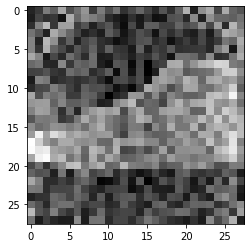

In [12]:
plt.imshow(X_test[0, :, :], cmap="gray"); # plot 1st image's 2nd feature map

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0

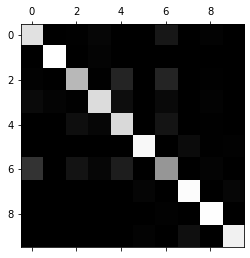

In [14]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

predictions = np.argmax(model.predict(X_test), axis=-1)
model_confusion_train = confusion_matrix(y_test, predictions);

plt.matshow(model_confusion_train, cmap=plt.cm.gray)
plt.show()

In [17]:
model.save("model3.h5")
test = keras.models.load_model("model3.h5")

In [18]:
score_test= test.evaluate(X_test, y_test)

516/516 [==============================] - 1s 3ms/step - loss: 0.4110 - sparse_categorical_accuracy: 0.8573


In [15]:
### OFFICLLY I HAVE 40K PARAMETERS WHICH IS LESS THAN 50K PARAMETERS

In [16]:
#keras_reg.model.summary()